In [1]:
import sys
import os

current_dir = os.path.dirname(os.path.abspath(''))
others_path = os.path.join(current_dir, '..', '..', 'gpr')

others_path = os.path.abspath(others_path)
if others_path not in sys.path:
    sys.path.append(others_path)

import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Callable
import cvxpy as cp
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

from eos import EosProperties
from kernels import Kernel
import gaussianprocess
from constrainedgp import CGP
import sampling as sam
import prepare_ceft as pc
import prepare_pqcd as pp
import anal_helpers as anal
from pqcd.pQCD import pQCD
from constants import get_phi, ns
import tmg_samplers as tmg
import constrain_on_chempot as coc

from pathlib import Path
notebook_dir = Path.cwd()

from scipy.linalg import cholesky, solve_triangular, cho_solve
from scipy.stats import norm
import scipy as sp
import pandas as pd


from aquarel import load_theme
theme = (
        load_theme("gruvbox_dark")
        .set_font("serif")
        .set_grid(True, width=0.2)
        )


theme = (
        load_theme("scientific")
        .set_font("serif")
        .set_grid(True, width=0.2)
        .set_lines(width=2)
        .set_axes(top=True, right=True)
        .set_ticks(width_major=1.2, width_minor=0.9, size_major=10, size_minor=4, direction='in')
        #.set_tick_labels(right=True, top=True)
        .set_overrides({
            "ytick.right": "true",
            "xtick.top": "true",
        })
        .set_title(pad=15)
        )
theme.apply()

#plot_dir = "/home/sam/thesis/writing/images/"

plot_dir = "/home/sam/thesis/941_5page_report/"

In [2]:
X = np.geomspace(1/2,2,100)
mu_grid = np.linspace(2.2,3,100)
n_cs2_arrays = []

for iteration in X:
    pQCD_temp = pQCD(iteration)
    n_temp  = np.vectorize(pQCD_temp.number_density)(mu_grid)/0.16 #nsat
    cs2_temp = np.vectorize(pQCD_temp.speed2)(mu_grid)
    X_temp = [n_temp,cs2_temp]
    n_cs2_arrays.append(X_temp)

n_cs2_arrays = np.asarray(n_cs2_arrays)

def append_bins(cs2_bin, n_bin, n_rounded, cs2_sum, cs2_count, i):
    
    cs2_bin.append(float(cs2_sum / cs2_count))
    if cs2_count != 1:
        n_bin.append(int(n_rounded[i - 1]))
    else:
        n_bin.append(int(n_rounded[i]))
        
binned_data = []

for k in range(len(X)):

    n_iter = n_cs2_arrays[k,0,:]
    cs2_iter = n_cs2_arrays[k,1,:]

    n_rounded = np.round(n_iter).astype(int)
    cs2_count = 1
    cs2_sum = cs2_iter[0]
    cs2_bin=[]
    n_bin=[]

    for i in range(len(n_rounded)): #n is rounded

        if i!=len(n_rounded)-1:

            if n_rounded[i+1] == n_rounded[i]:
                cs2_sum += cs2_iter[i+1]
                cs2_count += 1

            else:
                append_bins(cs2_bin, n_bin, n_rounded, cs2_sum, cs2_count, i)
                cs2_count = 1
                cs2_sum = cs2_iter[i+1]

        else:
            append_bins(cs2_bin, n_bin, n_rounded, cs2_sum, cs2_count, i)

    binned_data.append([n_bin,cs2_bin])


s = 25
e = 60
cs2_min = []
cs2_max = []
cs2_mean = []

for i in range(s,e):
    interest_n = i

    cs2_values_n = [cs2[n_i.index(interest_n)] for n_i, cs2 in binned_data if interest_n in n_i]
    cs2_min.append(np.min(cs2_values_n))
    cs2_max.append(np.max(cs2_values_n))
    cs2_mean.append(np.mean(cs2_values_n))

In [3]:
n_ceft, cs2_avg, cs2_upper, cs2_lower = anal.get_ceft_cs2()

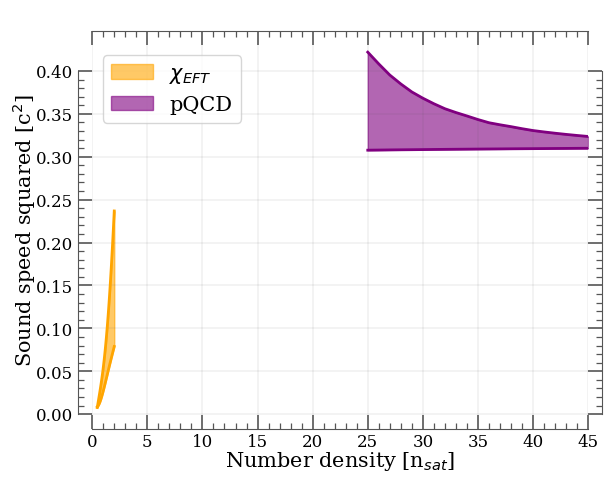

In [8]:
fig, ax = plt.subplots()

ax.plot(n_ceft, cs2_lower, color="orange")
ax.plot(n_ceft, cs2_upper, color="orange")
ax.fill_between(n_ceft, cs2_lower, cs2_upper, color='orange', alpha=0.6, label=r"$\chi_{EFT}$")

ax.plot(binned_data[0][0][1:-1], cs2_min, color = "purple")
ax.plot(binned_data[0][0][1:-1], cs2_max, color = "purple")

ax.fill_between(binned_data[0][0][1:-1], cs2_min, cs2_max, color='purple', alpha=0.6, label="pQCD")

ax.set_ylabel('Sound speed squared [c$^2$]', fontsize=15)
ax.set_xlabel('Number density [n$_{sat}$]', fontsize=15)
ax.legend()
ax.set_title(" ")
ax.set_xlim(0,45)

theme.apply_transforms()
plt.legend(loc='upper left', fontsize=15)
plt.savefig(plot_dir + "dataset.png", dpi=300)
plt.show()
